# TP03 ATDN02
# PAR JEREMY MOSCATO


## Excercice 1 

1.  L'optimisation bayésienne est une méthode qui cherche à optimiser une fonction coûteuse à évaluer en modélisant cette fonction à l’aide d’un processus gaussien, elle  permet de gérer les fonctions coûteuses à évaluer en modélisant la relation entre les entrées et les sorties avec un processus gaussien (GP)

2. Les processus gaussiens (PG) définissent une distribution de probabilité sur des fonctions, caractérisée par une moyenne et une covariance. Ils sont utilisés pour modéliser la fonction objective en raison de leur capacité à quantifier l'incertitude des prédictions.

3. Expected Improvement (EI) : privilégie les points susceptibles d’améliorer la meilleure solution connue.

Upper Confidence Bound (UCB) : favorise les points avec une haute incertitude, encourageant l’exploration.

Probability of Improvement (PI) : choisit les points avec une probabilité élevée d’améliorer la meilleure valeur actuelle.

Elles sont cruciales pour équilibrer l'exploration de nouvelles zones et l'exploitation des connaissances actuelles dans l'optimisation bayésienne. Elles attribuent une valeur à chaque point potentiel, permettant de favoriser l'exploration en donnant la priorité aux régions avec une forte incertitude. En même temps, elles encouragent l'exploitation en privilégiant les points avec une prédiction moyenne élevée, où la fonction objective est susceptible d'être performante.

### Implémentation et applications

4.

   Humidité (%)  Température (°C)  pH du sol  Précipitations (mm) Type de sol  \
0     52.472407         27.454043   6.055399           179.770446    Limoneux   
1     87.042858         23.402409   7.125703           169.795469    Limoneux   
2     73.919637         17.738190   8.118838            56.410516    Limoneux   
3     65.919509         30.344875   7.696675           135.311957     Sableux   
4     39.361118         27.118279   7.919683           145.048905     Sableux   

   Rendement agricole (t/ha)  
0                   7.038885  
1                   7.712547  
2                   6.587578  
3                   7.907268  
4                   6.889830  


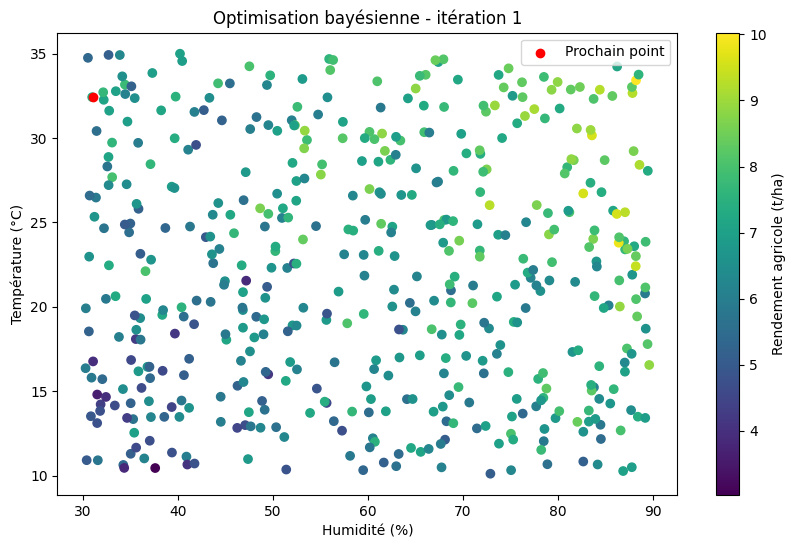

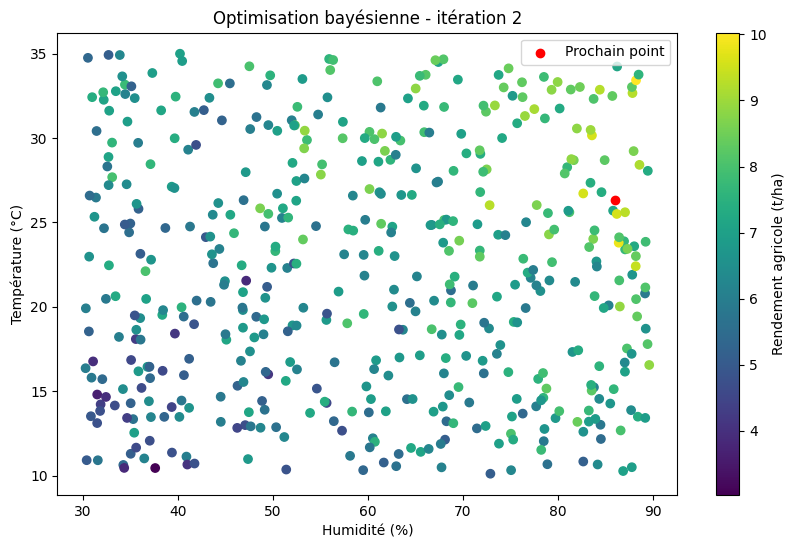

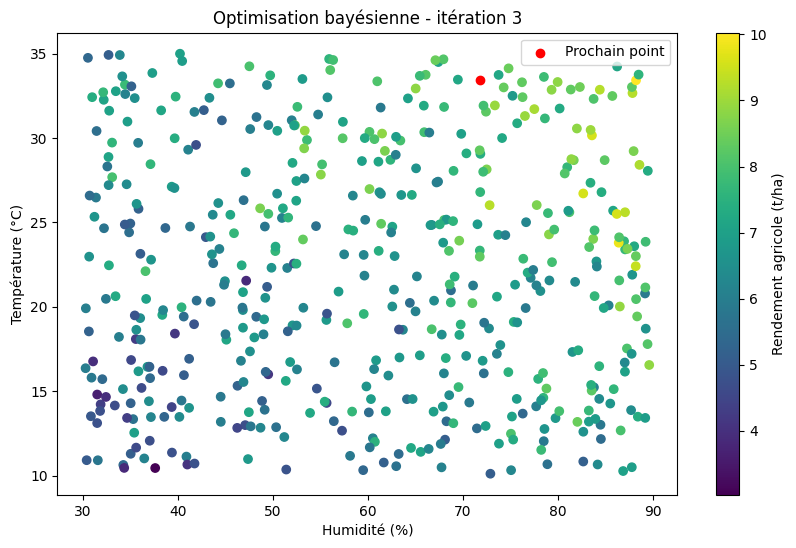

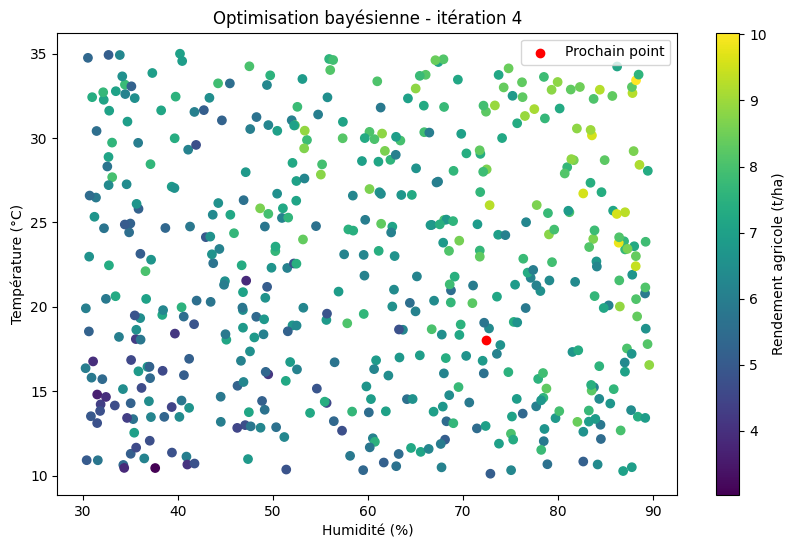

Meilleure combinaison trouvée : Humidité = 71.79904943261354 %, Température = 33.44998762354592 °C


In [26]:
# 1. Importer les bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt import Optimizer
from skopt.space import Real, Integer

# 2. Charger les données depuis le fichier CSV
data = pd.read_csv("tp2_atdn_donnees.csv")

# Vérification rapide des données pour s'assurer que la lecture est correcte
print(data.head())

# 3. Définir la fonction d'objectif (maximisation du rendement agricole)
def objectif(X):
    humidite, temperature = X
    # Calculer la différence entre le point actuel et tous les points du dataset
    diff = np.abs(data["Humidité (%)"] - humidite) + np.abs(data["Température (°C)"] - temperature)
    # Trouver l'index du point ayant la plus petite différence
    index = np.argmin(diff)
    # Retourner le rendement agricole associé à ce point
    return -data["Rendement agricole (t/ha)"].iloc[index]  # Maximisation : on minimise le négatif

# 4. Définir l'espace de recherche
space = [
    Real(30, 90, name='Humidité (%)'),
    Real(15, 35, name='Température (°C)')
]

# 5. Initialiser l'optimiseur bayésien
optimizer = Optimizer(space, base_estimator="GP", acq_func="EI", acq_optimizer="sampling")

# 6. Optimisation Bayésienne
n_iter = 4  # Nombre d'itérations
for i in range(n_iter):
    # Trouver le prochain point à explorer
    next_point = optimizer.ask()
    # Évaluer la fonction objectif
    f_val = objectif(next_point)
    # Ajouter la nouvelle observation dans l'optimiseur
    optimizer.tell([next_point], [f_val])
    
    # Visualisation des points explorés
    plt.figure(figsize=(10, 6))
    plt.scatter(data["Humidité (%)"], data["Température (°C)"], c=data["Rendement agricole (t/ha)"], cmap='viridis')
    plt.colorbar(label='Rendement agricole (t/ha)')
    plt.scatter(next_point[0], next_point[1], color='red', label='Prochain point')
    plt.title(f"Optimisation bayésienne - itération {i+1}")
    plt.xlabel("Humidité (%)")
    plt.ylabel("Température (°C)")
    plt.legend()
    plt.show()

# Afficher les meilleurs paramètres trouvés
best_params = optimizer.Xi[np.argmin(optimizer.yi)]
print("Meilleure combinaison trouvée : Humidité =", best_params[0], "%, Température =", best_params[1], "°C")



5.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



=== COMPARAISON DES MÉTHODES D'OPTIMISATION ===
Méthode              MSE        R²         Temps (s) 
--------------------------------------------------
Grid Search          0.8977     0.3005     57.45     
Random Search        0.9100     0.2910     11.51     
Bayesian Opt.        0.9554     0.2556     35.73     

=== MEILLEURS HYPERPARAMÈTRES ===
Grid Search: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 30}
Random Search: {'n_estimators': 70, 'min_samples_split': 2, 'max_depth': 5}
Bayesian Optimization: OrderedDict({'max_depth': 16, 'min_samples_split': 10, 'n_estimators': 56})


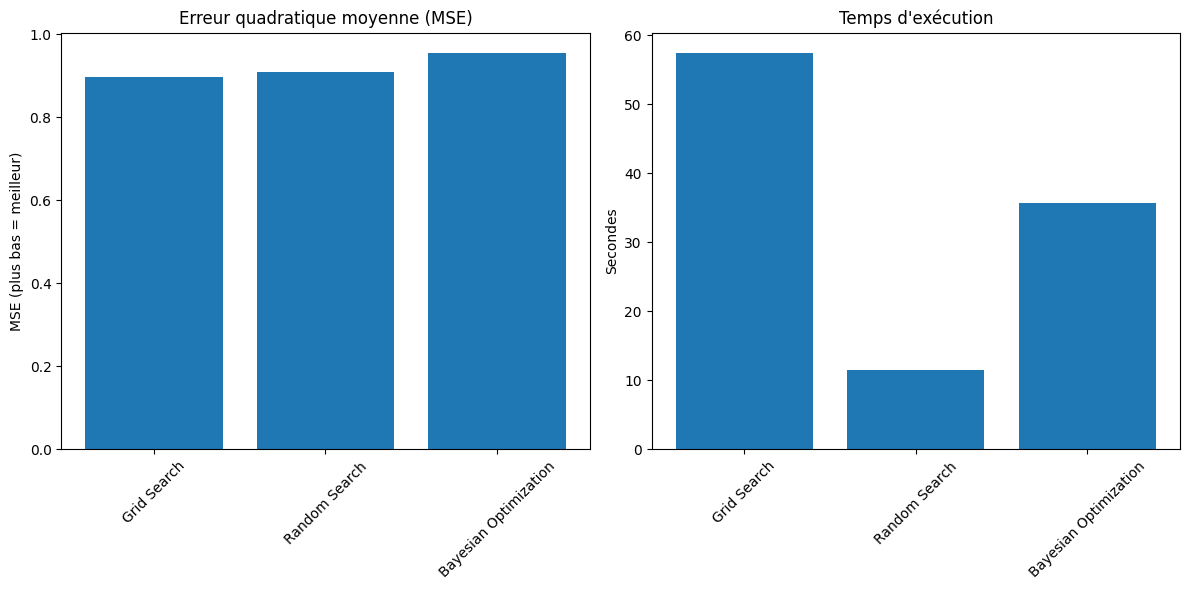

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from skopt import BayesSearchCV
from time import time

# 1. Charger les données agricoles
data = pd.read_csv("tp2_atdn_donnees.csv")

# Préparation des données (supposant que Rendement est la variable cible)
X = data[['Humidité (%)', 'Température (°C)']]  # Variables d'entrée
y = data['Rendement agricole (t/ha)']  # Variable cible

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Configuration des méthodes d'optimisation
# Définir l'espace de recherche commun pour tous les optimiseurs
param_space = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# 3. Les trois méthodes d'optimisation
# a) Grid Search
t0 = time()
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_space,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
grid_time = time() - t0

# b) Random Search
t0 = time()
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_space,
    n_iter=20,  # Nombre d'itérations
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
random_time = time() - t0

# c) Optimisation Bayésienne (avec scikit-optimize)
t0 = time()
bayes_search = BayesSearchCV(
    RandomForestRegressor(random_state=42),
    {
        'n_estimators': (10, 100),
        'max_depth': (3, 20),
        'min_samples_split': (2, 10)
    },
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
bayes_search.fit(X_train, y_train)
bayes_time = time() - t0

# 4. Évaluation des performances sur l'ensemble test
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {"name": name, "model": model, "mse": mse, "r2": r2}

results = [
    evaluate_model(grid_search.best_estimator_, "Grid Search"),
    evaluate_model(random_search.best_estimator_, "Random Search"),
    evaluate_model(bayes_search.best_estimator_, "Bayesian Optimization")
]

# 5. Affichage des résultats
print("\n=== COMPARAISON DES MÉTHODES D'OPTIMISATION ===")
print(f"{'Méthode':<20} {'MSE':<10} {'R²':<10} {'Temps (s)':<10}")
print("-" * 50)
print(f"{'Grid Search':<20} {results[0]['mse']:<10.4f} {results[0]['r2']:<10.4f} {grid_time:<10.2f}")
print(f"{'Random Search':<20} {results[1]['mse']:<10.4f} {results[1]['r2']:<10.4f} {random_time:<10.2f}")
print(f"{'Bayesian Opt.':<20} {results[2]['mse']:<10.4f} {results[2]['r2']:<10.4f} {bayes_time:<10.2f}")

# Afficher les meilleurs hyperparamètres trouvés
print("\n=== MEILLEURS HYPERPARAMÈTRES ===")
print("Grid Search:", grid_search.best_params_)
print("Random Search:", random_search.best_params_)
print("Bayesian Optimization:", bayes_search.best_params_)

# 6. Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
names = [r['name'] for r in results]
mse_values = [r['mse'] for r in results]
plt.bar(names, mse_values)
plt.title('Erreur quadratique moyenne (MSE)')
plt.ylabel('MSE (plus bas = meilleur)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
times = [grid_time, random_time, bayes_time]
plt.bar(names, times)
plt.title('Temps d\'exécution')
plt.ylabel('Secondes')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

6.

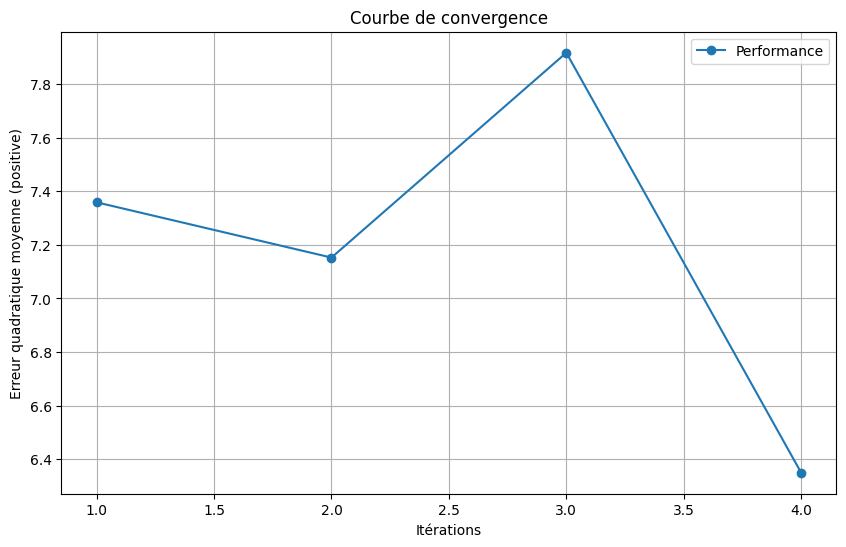

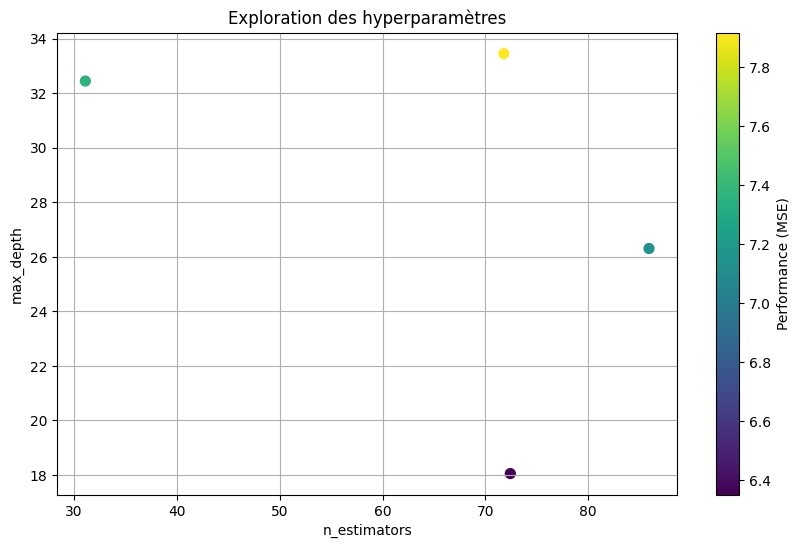

In [28]:
# Exemple de données simulées (remplacez par vos résultats réels)
iterations = np.arange(1, len(optimizer.yi) + 1)
scores = [-score for score in optimizer.yi]  # Convertir les scores négatifs en positifs

# Courbe de convergence
plt.figure(figsize=(10, 6))
plt.plot(iterations, scores, marker='o', label='Performance')
plt.xlabel('Itérations')
plt.ylabel('Erreur quadratique moyenne (positive)')
plt.title('Courbe de convergence')
plt.legend()
plt.grid()
plt.show()

# Visualisation des points explorés dans l'espace des hyperparamètres
points_explores = np.array(optimizer.Xi)
n_estimators = points_explores[:, 0]
max_depth = points_explores[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(n_estimators, max_depth, c=scores, cmap='viridis', s=50)
plt.colorbar(label='Performance (MSE)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('Exploration des hyperparamètres')
plt.grid()
plt.show()

7. D'après les ressources disponibles , on peut dire qu'en comparaison avec les méthodes classiques comme la recherche par grille (Grid Search) ou la recherche aléatoire (Random Search), l'optimisation bayésienne offre une meilleure efficacité en termes de nombre d'évaluations nécessaires, mais est d'une bien plus grande complexité.

Il est, dans notre cas, plus rapide mais moins efficace que les autres méthodes 

## Exercice 2 

8. L'inférence bayésienne est un processus statistique qui met à jour des croyances probabilistes initiales (distribution a priori) en incorporant de nouvelles observations via le théorème de Bayes, produisant ainsi une distribution a posteriori qui représente nos croyances actualisées.

9. Les méthodes à noyau transforment les données dans un espace de dimension supérieure pour permettre une séparation plus efficace, et leur lien avec les processus gaussiens réside dans le fait que ces derniers peuvent être vus comme une généralisation bayésienne des modèles à noyau, où la fonction à estimer est modélisée comme une distribution de fonctions aléatoires définies par un noyau.

10. La distribution a priori représente les connaissances initiales sur un paramètre avant d'observer des données, basée sur des études ou des hypothèses. La distribution a posteriori, obtenue via le théorème de Bayes, combine la distribution a priori avec les nouvelles données pour mettre à jour les estimations.

11.

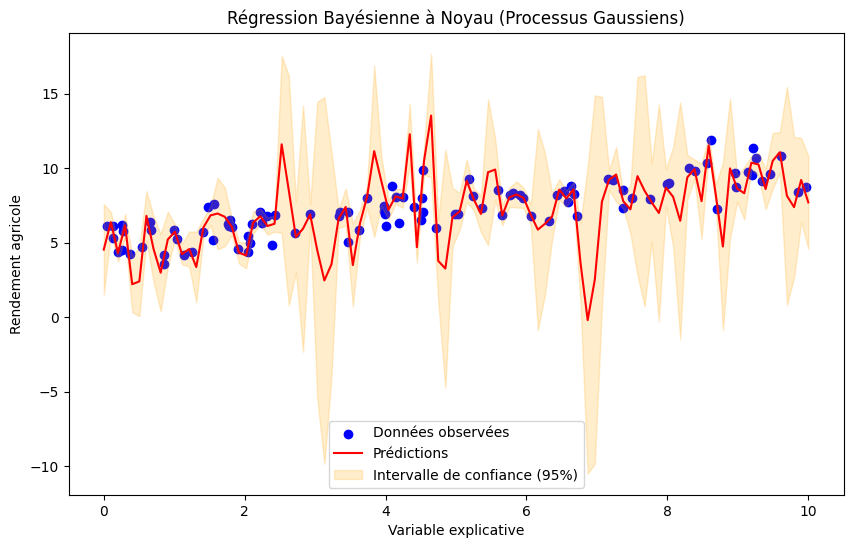

In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Exemple de données
X = np.random.rand(100, 1) * 10  # Variable explicative (par exemple, humidité)
y = 5 + 0.5 * X[:, 0] + np.random.normal(0, 1, 100)  # Rendement agricole avec bruit

# Définir un noyau (RBF avec une constante)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Modèle de régression bayésienne
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)

# Ajuster le modèle
gp.fit(X, y)

# Prédictions
X_pred = np.linspace(0, 10, 100).reshape(-1, 1)
y_pred, sigma = gp.predict(X_pred, return_std=True)

# Visualisation
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Données observées')
plt.plot(X_pred, y_pred, color='red', label='Prédictions')
plt.fill_between(X_pred[:, 0], y_pred - 2 * sigma, y_pred + 2 * sigma,
                 color='orange', alpha=0.2, label='Intervalle de confiance (95%)')
plt.xlabel('Variable explicative')
plt.ylabel('Rendement agricole')
plt.legend()
plt.title('Régression Bayésienne à Noyau (Processus Gaussiens)')
plt.show()


On remarque que les prédictions sont très bonne à 95% près.

12.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KernelDensity
from sklearn.svm import SVC

# Exemple de données climatiques et types de sol
np.random.seed(42)
X = np.random.rand(300, 2) * 10  # Variables climatiques : humidité et température
y = np.random.choice(['argileux', 'sableux', 'limoneux'], size=300)  # Types de sol

# Conversion des labels en numériques pour faciliter la classification
label_mapping = {'argileux': 0, 'sableux': 1, 'limoneux': 2}
y_numeric = np.array([label_mapping[label] for label in y])

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.3, random_state=42)

# Estimation des densités par noyaux pour chaque classe
kdes = {}
for label in np.unique(y_train):
    kdes[label] = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(X_train[y_train == label])

# Classification bayésienne à noyau
def classify_bayesian(X_test):
    log_probs = []
    for label in kdes:
        log_prob = kdes[label].score_samples(X_test)  # Log-probabilité conditionnelle p(x|y)
        log_probs.append(log_prob)
    log_probs = np.array(log_probs).T
    return np.argmax(log_probs, axis=1)  # Classe avec la probabilité maximale

# Prédictions sur l'ensemble de test
y_pred_bayesian = classify_bayesian(X_test)

# Résultats
print("Classification Bayésienne à Noyau")
print("Accuracy:", accuracy_score(y_test, y_pred_bayesian))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bayesian))


# Entraînement du SVM
svm = SVC(kernel='rbf', gamma='scale', C=1.0)
svm.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_svm = svm.predict(X_test)

# Résultats
print("\nClassification avec SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


Classification Bayésienne à Noyau
Accuracy: 0.4
Confusion Matrix:
 [[ 8  9  7]
 [11 14 11]
 [ 9  7 14]]

Classification avec SVM
Accuracy: 0.4444444444444444
Confusion Matrix:
 [[ 9  6  9]
 [ 7 14 15]
 [ 8  5 17]]


On remarque que le SVm est un petit plus efficace que la classification bayesienne à noyau.

13. Plusieurs sources d'incertitudes peuvent être cités : l'incertitude liée au model, l'incertitued liée aux données (Bruit, etc;.) et l'incertitude liée au paramètre.
Dans notre cas, on peut dire qu'il y a des incertitudes lorsqu'on s'approche des frontières de décision (différents types de sols), ou bien la ou les données sont rares (comme avec des sols rares)

14 et 15.

In [31]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèles SVM avec différents noyaux
kernels = ['linear', 'rbf', 'poly']
results = {}

for kernel in kernels:
    if kernel == 'poly':
        model = SVC(kernel=kernel, degree=3, C=1.0)  # Noyau polynomial avec degré=3
    else:
        model = SVC(kernel=kernel, C=1.0)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[kernel] = accuracy

# Afficher les résultats
for kernel, acc in results.items():
    print(f"Noyau {kernel}: Précision = {acc:.2f}")

Noyau linear: Précision = 0.42
Noyau rbf: Précision = 0.44
Noyau poly: Précision = 0.34


On peut cité comme différence notoires entre les noyaux le contexte de leurs efficacités : 
- le noyau linéaire sera performant si les classes sont séparables par une ligne ou un plan.
- le noyau RBF sera très performant pour des frontières complexes et non linéaires.
- le noyau polynomial sera performant si les relations polynomiales dominent dans les données.

La distribution a priori joue un rôle crucial lorsque peu de données sont disponibles, en intégrant des connaissances préalables, mais son impact diminue avec un grand nombre d'observations.